In [1]:
import os, sys
from pathlib import Path

# Use project root (one level up from notebooks if needed)
here = Path.cwd()
root = here if (here / 'src').exists() and (here / 'data').exists() else here.parent
os.chdir(root)
sys.path.append(str(root))

print('Working directory:', Path.cwd())

CANDIDATE_CSVS = [
    'data/WA_Fn-UseC_-Telco-Customer-Churn.csv',
    'data/TelcoCustomerChurn.csv'
]
CSV_PATH = None
for p in CANDIDATE_CSVS:
    if Path(p).exists():
        CSV_PATH = p
        break
assert CSV_PATH is not None, "CSV not found in data/"
print('Dataset:', CSV_PATH)


Working directory: c:\Users\User\Documents\GitHub\6006CEM\Task1_Classification
Dataset: data/TelcoCustomerChurn.csv


In [2]:

import numpy as np
import matplotlib.pyplot as plt

from src.preprocess import load_raw, clean_basic, split_Xy, make_train_test, build_preprocessor
from src.imbalance_handler import smote_balance, describe_distribution
from src.models import get_random_forest, build_keras_model
from src.evaluate import evaluate_binary, plot_confusion_matrix, plot_roc

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from pathlib import Path
Path('results/confusion_matrices').mkdir(parents=True, exist_ok=True)
Path('results/metrics').mkdir(parents=True, exist_ok=True)


In [3]:
## Load, Clean, Split
raw = load_raw(CSV_PATH)
df  = clean_basic(raw)
X, y = split_Xy(df)

X_train, X_test, y_train, y_test = make_train_test(X, y, test_size=0.2, random_state=42)
print('Train distribution:', describe_distribution(y_train))
print('Test  distribution:', describe_distribution(y_test))

preprocessor = build_preprocessor(X_train)


Train distribution: {0: '4139 (73.46%)', 1: '1495 (26.54%)'}
Test  distribution: {0: '1035 (73.46%)', 1: '374 (26.54%)'}


In [4]:
## Random Forest (Baseline)
rf = get_random_forest()
rf_pipe = Pipeline([('prep', preprocessor), ('model', rf)])
rf_pipe.fit(X_train, y_train)

y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

metrics_rf_base = evaluate_binary(y_test, y_pred_rf, y_proba_rf)
print(metrics_rf_base)
print("Random Forest (Baseline) Metrics:")
for key, val in metrics_rf_base.items():
    print(f"  {key:<10}: {val:.4f}")

plot_confusion_matrix(y_test, y_pred_rf, 'results/confusion_matrices/rf_confusion_nb.png', title='RF Confusion (NB)')
plot_roc(y_test, y_proba_rf, 'results/confusion_matrices/rf_roc_nb.png', title='RF ROC (NB)')

{'accuracy': 0.7842441447835344, 'precision': 0.6223776223776224, 'recall': 0.47593582887700536, 'f1': 0.5393939393939394, 'roc_auc': 0.8233589087809037}
Random Forest (Baseline) Metrics:
  accuracy  : 0.7842
  precision : 0.6224
  recall    : 0.4759
  f1        : 0.5394
  roc_auc   : 0.8234


In [5]:
## Neural Network MLP (Baseline)
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)
X_train_bal, y_train_bal = smote_balance(X_train_trans, y_train)

nn_base = build_keras_model(input_dim=X_train_bal.shape[1], hidden_units=64, dropout=0.2, lr=1e-3)
history = nn_base.fit(X_train_bal, y_train_bal, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

y_proba_nn_base = nn_base.predict(X_test_trans, verbose=0).ravel()
y_pred_nn_base = (y_proba_nn_base >= 0.5).astype(int)

metrics_nn_base = evaluate_binary(y_test, y_pred_nn_base, y_proba_nn_base)
print("Neural Network (Baseline): Metrics")
for key, val in metrics_nn_base.items():
    print(f"  {key:<10}: {val:.4f}")

plot_confusion_matrix(y_test, y_pred_nn_base, 'results/confusion_matrices/nn_confusion_nb.png', title='NN Confusion (NB)')
plot_roc(y_test, y_proba_nn_base, 'results/confusion_matrices/nn_roc_nb.png', title='NN ROC (NB)')


Neural Network (Baseline): Metrics
  accuracy  : 0.7708
  precision : 0.5573
  recall    : 0.6631
  f1        : 0.6056
  roc_auc   : 0.8372


In [6]:
## Random Forest (Tuned)
param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [1, 2, 3],
}
grid_rf = GridSearchCV(rf_pipe, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

print("\nBest RF params:", grid_rf.best_params_)
print("Best CV ROC-AUC:", round(grid_rf.best_score_, 4))

best_rf = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
y_proba_rf_tuned = best_rf.predict_proba(X_test)[:, 1]
metrics_rf_tuned = evaluate_binary(y_test, y_pred_rf_tuned, y_proba_rf_tuned)
print("\nRF Tuned metrics:")
print("Random Forest (Tuned) Metrics")
for key, val in metrics_rf_tuned.items():
    print(f"  {key:<10}: {val:.4f}")


Fitting 3 folds for each of 144 candidates, totalling 432 fits

Best RF params: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Best CV ROC-AUC: 0.8473

RF Tuned metrics:
Random Forest (Tuned) Metrics
  accuracy  : 0.7651
  precision : 0.5424
  recall    : 0.7353
  f1        : 0.6243
  roc_auc   : 0.8419


Top 10 Random Forest features:
  tenure                                   0.1237
  Contract_Month-to-month                  0.1221
  TotalCharges                             0.1031
  MonthlyCharges                           0.0711
  Contract_Two year                        0.0642
  OnlineSecurity_No                        0.0617
  TechSupport_No                           0.0515
  InternetService_Fiber optic              0.0477
  PaymentMethod_Electronic check           0.0336
  Contract_One year                        0.0201

Saved JSON to results/metrics/rf_feature_importance_nb.json


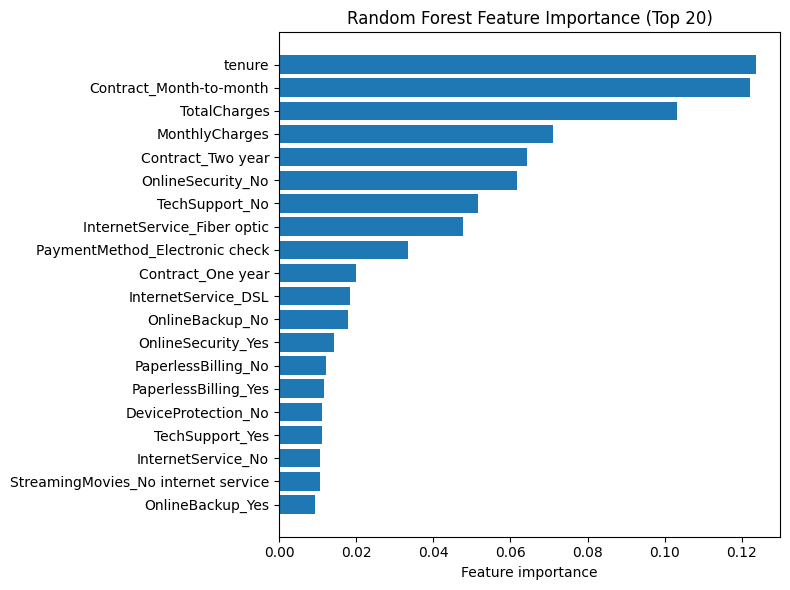

Feature importance plot saved to: results/feature_importance/rf_feature_importance_nb.png


In [7]:
## Random Forest Feature Importance (from tuned model)

import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt

# Get the fitted preprocessor + RF model from the tuned pipeline
rf_prep = best_rf.named_steps["prep"]
rf_model = best_rf.named_steps["model"]

# Get the feature names after preprocessing (numeric + one-hot)
feature_names = rf_prep.get_feature_names_out()
importances = rf_model.feature_importances_

# Sort by importance (descending)
idx = np.argsort(importances)[::-1]
feature_names_sorted = feature_names[idx]
importances_sorted = importances[idx]

# Print top 10 features in the notebook
print("Top 10 Random Forest features:")
for name, val in list(zip(feature_names_sorted, importances_sorted))[:10]:
    print(f"  {name:<40} {val:.4f}")

# Save all feature importances to JSON for use in the report
fi_dict = {name: float(val) for name, val in zip(feature_names_sorted, importances_sorted)}
Path("results/metrics").mkdir(parents=True, exist_ok=True)
with open("results/metrics/rf_feature_importance_nb.json", "w") as f:
    json.dump(fi_dict, f, indent=2)
print("\nSaved JSON to results/metrics/rf_feature_importance_nb.json")

# Optional: bar chart of top 20 features for your Appendix / slides
top_k = 20
top_names = feature_names_sorted[:top_k]
top_vals = importances_sorted[:top_k]

plt.figure(figsize=(8, 6))
plt.barh(range(len(top_names)), top_vals)
plt.yticks(range(len(top_names)), top_names)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Random Forest Feature Importance (Top 20)")
Path("results/feature_importance").mkdir(parents=True, exist_ok=True)
out_path = "results/feature_importance/rf_feature_importance_nb.png"
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()

print(f"Feature importance plot saved to: {out_path}")


In [8]:
## Neural Network MLP (Tuned)
import keras_tuner as kt


from tensorflow import keras

def build_model_tunable(hp):
    units = hp.Int('units', 32, 128, step=32)
    dropout = hp.Float('dropout', 0.1, 0.5, step=0.1)
    lr = hp.Choice('lr', [1e-2, 1e-3, 1e-4])

    m = keras.Sequential([
        keras.layers.Input(shape=(X_train_bal.shape[1],)),
        keras.layers.Dense(units, activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    return m

tuner = kt.RandomSearch(
    build_model_tunable, objective='val_accuracy',
    max_trials=5, executions_per_trial=1,
    directory='results', project_name='churn_nn_tuning'
)
tuner.search(X_train_bal, y_train_bal, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

best_hp = tuner.get_best_hyperparameters(1)[0]
best_nn = build_keras_model(
    input_dim=X_train_bal.shape[1],
    hidden_units=best_hp.get('units'),
    dropout=best_hp.get('dropout'),
    lr=best_hp.get('lr'),
)

best_nn.fit(
    X_train_bal, y_train_bal,
    validation_split=0.2,
    epochs=20, batch_size=32,
    verbose=0
)

print("\nBest NN hyperparameters:")
print({k: best_hp.get(k) for k in ['units','dropout','lr']})

y_proba_nn_tuned = best_nn.predict(X_test_trans, verbose=0).ravel()
y_pred_nn_tuned = (y_proba_nn_tuned >= 0.5).astype(int)
metrics_nn_tuned = evaluate_binary(y_test, y_pred_nn_tuned, y_proba_nn_tuned)
print("\nNN Tuned metrics:")
print("Neural Network (Tuned) Metrics")
for key, val in metrics_nn_tuned.items():
    print(f"  {key:<10}: {val:.4f}")


Reloading Tuner from results\churn_nn_tuning\tuner0.json

Best NN hyperparameters:
{'units': 64, 'dropout': 0.4, 'lr': 0.01}

NN Tuned metrics:
Neural Network (Tuned) Metrics
  accuracy  : 0.7807
  precision : 0.5783
  recall    : 0.6417
  f1        : 0.6084
  roc_auc   : 0.8345


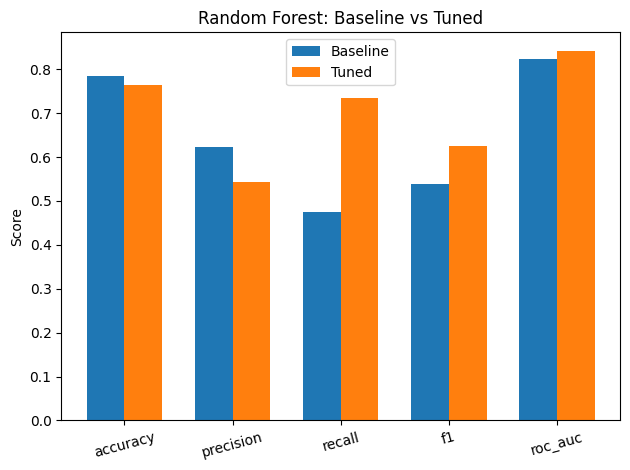

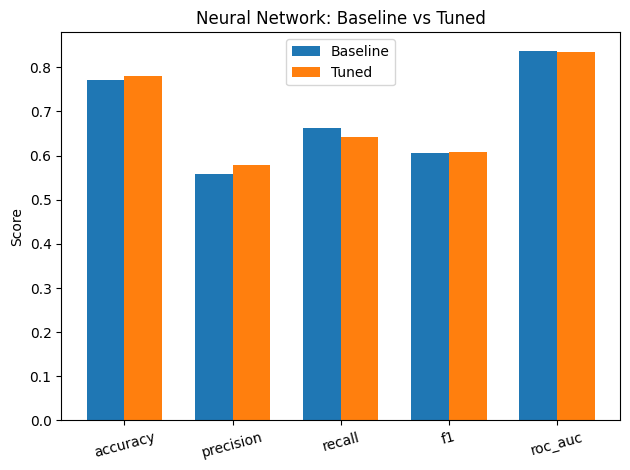

Saved metrics comparison to results/metrics/summary_with_tuning.json


In [9]:
## Comparison Charts
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_bars(model_name, base_metrics, tuned_metrics, keys, out_path):
    labels = keys
    base_vals = [base_metrics.get(k, np.nan) for k in keys]
    tuned_vals = [tuned_metrics.get(k, np.nan) for k in keys]

    plt.figure()
    x = np.arange(len(labels))
    width = 0.35
    plt.bar(x - width/2, base_vals, width, label='Baseline')
    plt.bar(x + width/2, tuned_vals, width, label='Tuned')
    plt.xticks(x, labels, rotation=15)
    plt.ylabel('Score')
    plt.title(f'{model_name}: Baseline vs Tuned')
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

rf_keys = ['accuracy','precision','recall','f1','roc_auc']
plot_metric_bars('Random Forest', metrics_rf_base, metrics_rf_tuned, rf_keys,
                 'results/metrics/rf_baseline_vs_tuned.png')

nn_keys = ['accuracy','precision','recall','f1','roc_auc']
plot_metric_bars('Neural Network', metrics_nn_base, metrics_nn_tuned, nn_keys,
                 'results/metrics/nn_baseline_vs_tuned.png')

import json, pathlib
summary = {
    'random_forest': {'baseline': metrics_rf_base, 'tuned': metrics_rf_tuned},
    'neural_network': {'baseline': metrics_nn_base, 'tuned': metrics_nn_tuned},
}
pathlib.Path('results/metrics').mkdir(parents=True, exist_ok=True)
with open('results/metrics/summary_with_tuning.json','w') as f:
    json.dump(summary, f, indent=2)
print("Saved metrics comparison to results/metrics/summary_with_tuning.json")
